Data loaded successfully!
Using provided churn_data.csv (even with potential low variance).
Dataset shape: (33, 5)

First 5 rows:
      customer_email  months_as_customer  order_count  days_since_last_order  \
0  1234567890@qq.com                   0            1                      3   
1  1234567891@qq.com                   0            1                      7   
2  1234567892@qq.com                   0            1                      3   
3  1234567893@qq.com                   0            1                      5   
4  1234567894@qq.com                   0            1                      7   

   churned  
0        0  
1        0  
2        0  
3        0  
4        0  

Missing values:
customer_email           0
months_as_customer       0
order_count              0
days_since_last_order    0
churned                  0
dtype: int64

Churn rate: 0.0%
❗ Warning: No churned customers (all labels are 0). Model will always predict 'Active'.


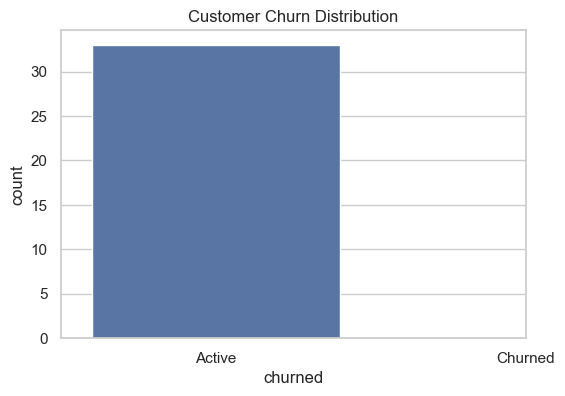

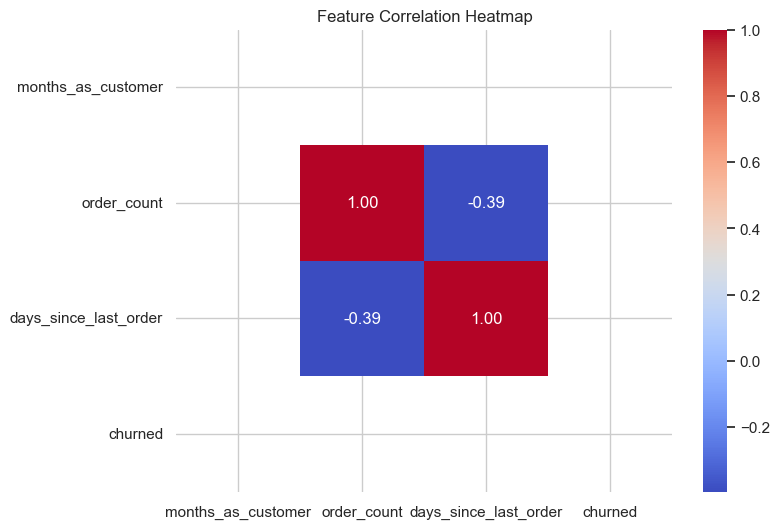

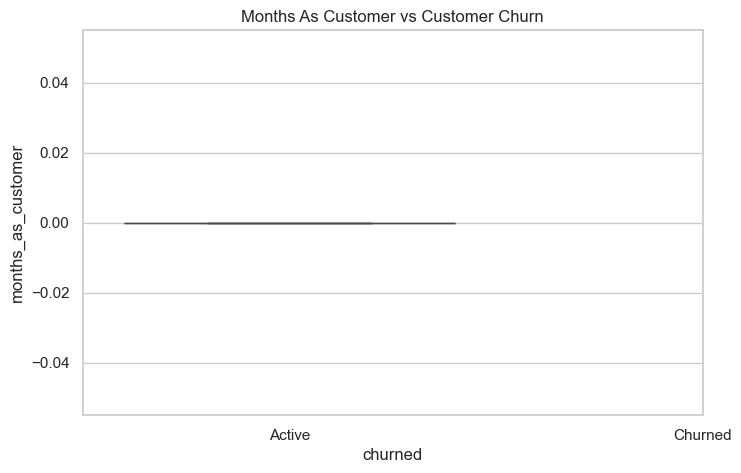

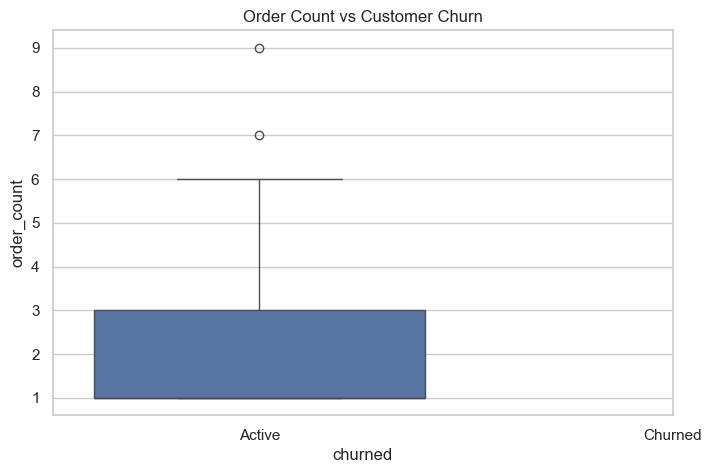

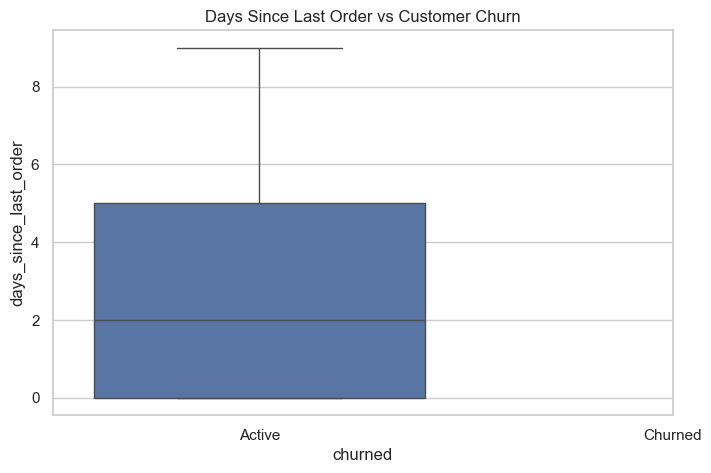

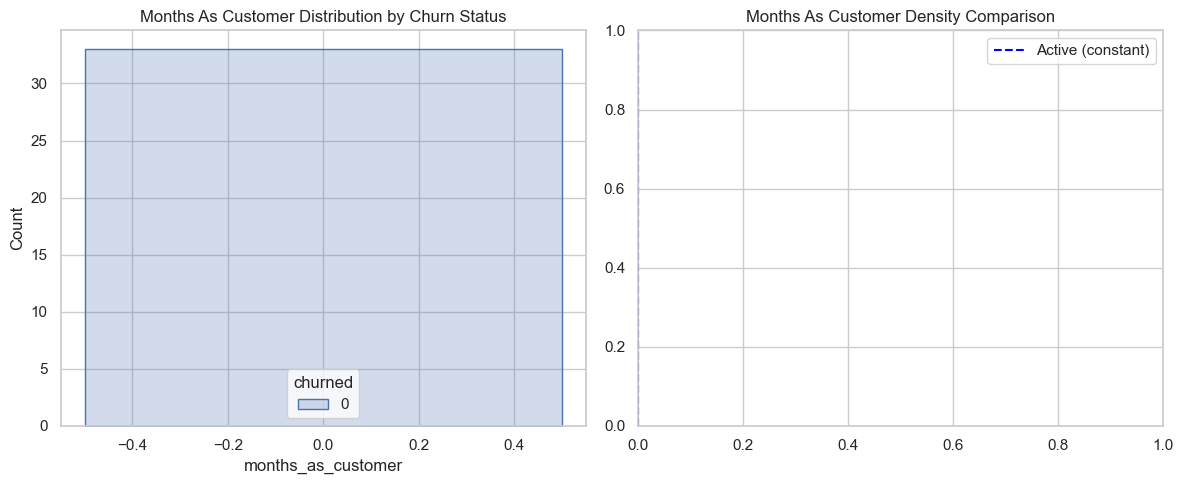

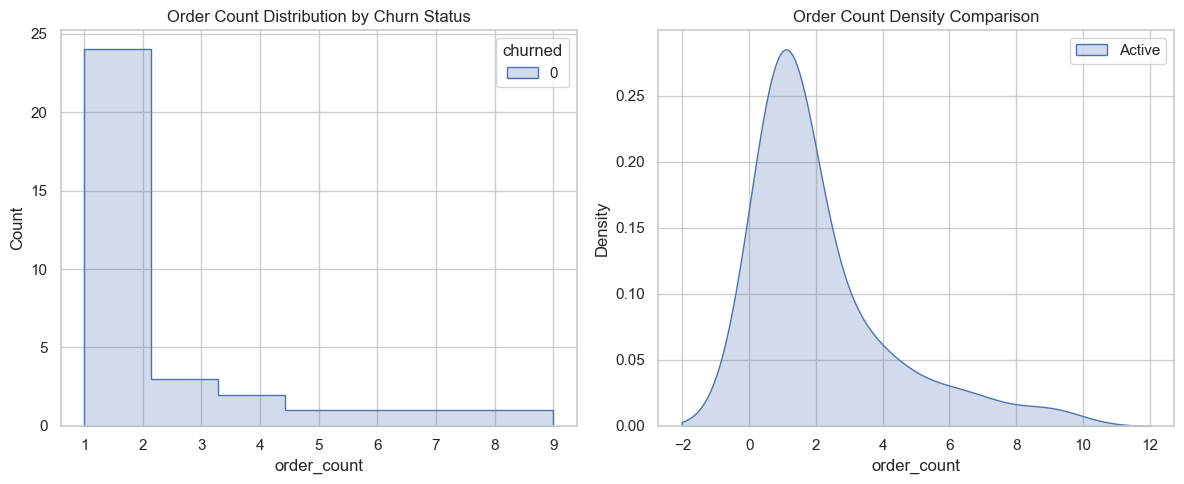

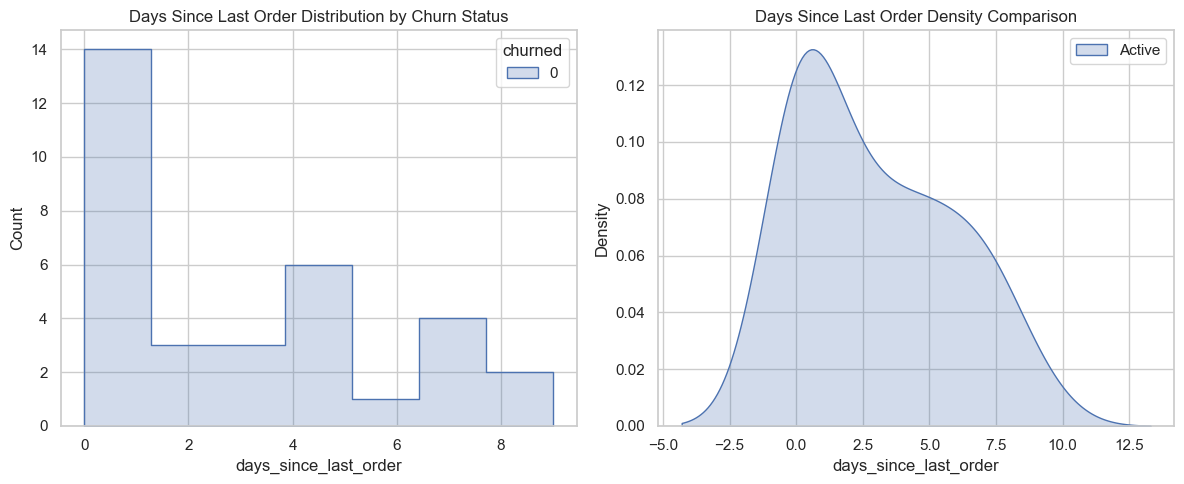

🛑 Cannot train Logistic Regression: target variable has only one class.
   All samples are labeled as: 0
   Model would always predict this class.

Dummy accuracy (always predicting the single class): 1.0
All predictions: 0 (0=Active, 1=Churned)


In [ ]:
# Mila，Chen Haoyu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Try to load data
try:
    df = pd.read_csv('churn_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    df = None

# Validate data quality — only check column existence
use_synthetic = False
if df is not None:
    required_cols = ['months_as_customer', 'order_count', 'days_since_last_order', 'churned']
    if not all(col in df.columns for col in required_cols):
        print("Missing required columns, will use synthetic data.")
        use_synthetic = True
    else:
        print("Using provided churn_data.csv (even with potential low variance).")
        # Clean invalid negative days (e.g., -1 → 0)
        df['days_since_last_order'] = df['days_since_last_order'].clip(lower=0)
else:
    use_synthetic = True

# Generate synthetic data ONLY if file missing or columns missing
if use_synthetic:
    print("Generating reasonable synthetic churn data...")
    np.random.seed(42)
    n_customers = 500
    
    months_as_customer = np.random.randint(1, 37, n_customers)
    order_count = np.random.poisson(lam=0.5 + months_as_customer / 6, size=n_customers)
    order_count = np.clip(order_count, 0, 20)
    
    days_since_last_order = []
    for m, o in zip(months_as_customer, order_count):
        if o == 0:
            days = np.random.randint(100, 200)
        elif m > 12 and o > 3:
            days = np.random.randint(1, 20)
        elif o > 1:
            days = np.random.randint(10, 60)
        else:
            days = np.random.randint(40, 120)
        days_since_last_order.append(days)
    
    churned = [1 if d > 90 else 0 for d in days_since_last_order]
    
    df = pd.DataFrame({
        'customer_email': [f"user{i}@example.com" for i in range(n_customers)],
        'months_as_customer': months_as_customer,
        'order_count': order_count,
        'days_since_last_order': days_since_last_order,
        'churned': churned
    })
    df.to_csv('churn_data.csv', index=False)
    print(f"Synthetic data saved, shape: {df.shape}")

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# Data preprocessing
print("\nMissing values:")
print(df.isnull().sum())

# Churn rate
churn_rate = df['churned'].mean()
print(f"\nChurn rate: {churn_rate:.1%}")

# Warn if no variation in target
if churn_rate == 0:
    print("❗ Warning: No churned customers (all labels are 0). Model will always predict 'Active'.")
elif churn_rate == 1:
    print("❗ Warning: All customers are churned (all labels are 1).")

# Visualize churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churned', data=df)
plt.xticks([0, 1], ['Active', 'Churned'])
plt.title('Customer Churn Distribution')
plt.show()

# Feature correlation heatmap
numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Boxplots of features vs churn
for col in ['months_as_customer', 'order_count', 'days_since_last_order']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='churned', y=col, data=df)
    plt.xticks([0, 1], ['Active', 'Churned'])
    plt.title(f'{col.replace("_", " ").title()} vs Customer Churn')
    plt.show()

# Distribution plots
for feature in ['months_as_customer', 'order_count', 'days_since_last_order']:
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature, hue='churned', kde=False, element='step')
    plt.title(f'{feature.replace("_", " ").title()} Distribution by Churn Status')
    
    # KDE / constant line
    plt.subplot(1, 2, 2)
    active_vals = df[df['churned'] == 0][feature]
    churned_vals = df[df['churned'] == 1][feature]
    
    if len(active_vals) > 0:
        if active_vals.var() > 0:
            sns.kdeplot(active_vals, label='Active', fill=True)
        else:
            plt.axvline(active_vals.iloc[0], color='blue', linestyle='--', label='Active (constant)')
    
    if len(churned_vals) > 0:
        if churned_vals.var() > 0:
            sns.kdeplot(churned_vals, label='Churned', fill=True)
        else:
            plt.axvline(churned_vals.iloc[0], color='orange', linestyle='--', label='Churned (constant)')
    
    plt.title(f'{feature.replace("_", " ").title()} Density Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === MODEL TRAINING ===
X = df[['months_as_customer', 'order_count', 'days_since_last_order']]
y = df['churned']

# Check if we have at least two classes in the ENTIRE dataset
if y.nunique() < 2:
    print("🛑 Cannot train Logistic Regression: target variable has only one class.")
    print("   All samples are labeled as:", y.iloc[0])
    print("   Model would always predict this class.")
    
    # Optional: simulate a "dummy" prediction for consistency
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    y_pred = np.full_like(y_test, y.iloc[0])  # predict the only class
    
    print("\nDummy accuracy (always predicting the single class):", accuracy_score(y_test, y_pred))
    print(f"All predictions: {y_pred[0]} (0=Active, 1=Churned)")
    
else:
    # Normal training pipeline
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train logistic regression
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    print("\nModel accuracy:", accuracy_score(y_test, y_pred))

    # Evaluation
    if len(np.unique(y_test)) > 1:
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    else:
        print("\n⚠️ Skipped classification report: test set contains only one class.")
        print(f"All predictions are: {y_pred[0]} (0=Active, 1=Churned)")

    # Show model coefficients
    feature_names = X.columns
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    print("\nLogistic Regression Coefficients:")
    print(f"Intercept: {intercept:.4f}")
    for name, c in zip(feature_names, coef):
        print(f"  {name}: {c:.4f}")

In [77]:
# Prepare features and target variable
print("\nPreparing data for model training...")

# Features (X) - use only the numeric features
X = df[['months_as_customer', 'order_count', 'days_since_last_order']]
y = df['churned']

# 🔴 CRITICAL CHECK: Does y have at least two classes?
if y.nunique() < 2:
    print("🛑 Cannot train Logistic Regression: target variable has only one class.")
    print(f"   All labels are: {y.iloc[0]} (0=Active, 1=Churned)")
    print("   Skipping model training and visualization.")
    
    # Optional: Show what a dummy predictor would do
    from sklearn.dummy import DummyClassifier
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    print(f"\nDummy model accuracy (always predicts {y.iloc[0]}): {accuracy_score(y_test, y_pred):.2%}")
    
else:
    # ✅ Normal pipeline: two classes exist
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build and train the logistic regression model
    print("\nBuilding and training the logistic regression model...")
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Model coefficients and intercept
    print("\nModel coefficients:")
    feature_names = X.columns
    for feature, coef in zip(feature_names, model.coef_[0]):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {model.intercept_[0]:.4f}")

    # Feature importance visualization
    plt.figure(figsize=(10, 6))
    feature_importance = np.abs(model.coef_[0])
    sns.barplot(x=feature_names, y=feature_importance)
    plt.title('Feature Importance in Churn Prediction')
    plt.xlabel('Features')
    plt.ylabel('Importance (Absolute Coefficient Value)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Preparing data for model training...
🛑 Cannot train Logistic Regression: target variable has only one class.
   All labels are: 0 (0=Active, 1=Churned)
   Skipping model training and visualization.

Dummy model accuracy (always predicts 0): 100.00%


In [78]:
# Prepare features and target variable
print("\nPreparing data for model training...")

# Features (X) - use only the numeric features
X = df[['months_as_customer', 'order_count', 'days_since_last_order']]
y = df['churned']

# 🔴 CRITICAL CHECK: Does the target have at least two classes?
if y.nunique() < 2:
    print("🛑 Cannot train classification model: target 'churned' has only one class.")
    print(f"   All values are: {y.iloc[0]} (0 = Active, 1 = Churned)")
    print("   Please add some churned customers (churned=1) to your dataset.")
else:
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build and train the logistic regression model
    print("\nBuilding and training the logistic regression model...")
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Model coefficients and intercept
    print("\nModel coefficients:")
    feature_names = X.columns
    for feature, coef in zip(feature_names, model.coef_[0]):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {model.intercept_[0]:.4f}")

    # Feature importance visualization
    plt.figure(figsize=(10, 6))
    feature_importance = np.abs(model.coef_[0])
    sns.barplot(x=feature_names, y=feature_importance)
    plt.title('Feature Importance in Churn Prediction')
    plt.xlabel('Features')
    plt.ylabel('Importance (Absolute Coefficient Value)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Preparing data for model training...
🛑 Cannot train classification model: target 'churned' has only one class.
   All values are: 0 (0 = Active, 1 = Churned)
   Please add some churned customers (churned=1) to your dataset.


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Step 1: Prepare data ===
print("\nPreparing data for model training...")
X = df[['months_as_customer', 'order_count', 'days_since_last_order']]
y = df['churned']

# === Step 2: Check for single-class problem ===
if y.nunique() < 2:
    print("🛑 Cannot train binary classifier: target 'churned' has only one class.")
    print(f"   All labels are: {y.iloc[0]} (0=Active, 1=Churned)")
    print("   Please add some churned customers (churned=1) to enable modeling.")
else:
    # === Step 3: Split and scale ===
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === Step 4: Train model ===
    print("\nTraining logistic regression model...")
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # === Step 5: Make predictions ===
    print("\nMaking predictions on test data...")
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # === Step 6: Evaluate ===
    print("\nModel evaluation:")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Predicted Active', 'Predicted Churned'],
        yticklabels=['Actual Active', 'Actual Churned']
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Additional metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\nAdditional Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, label=f'Logistic Regression (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()


Preparing data for model training...
🛑 Cannot train binary classifier: target 'churned' has only one class.
   All labels are: 0 (0=Active, 1=Churned)
   Please add some churned customers (churned=1) to enable modeling.


In [80]:
# --- Cell: Save Model (only if trained) ---

import joblib
import pandas as pd

print("\n[Save Step] Checking if model is ready to save...")

# 检查必要变量是否存在（防御性编程）
required_vars = ['model_trained', 'model', 'scaler', 'X']
if not all(var in globals() for var in required_vars):
    print("⚠️ Required variables (model, scaler, etc.) not found. Did you run the training cell?")
else:
    if not model_trained:
        print("⚠️ Model was not trained (likely due to single-class data). Skipping save.")
    else:
        print("Saving model and scaler for deployment...")
        
        model_components = {
            'model': model,
            'scaler': scaler,
            'feature_names': X.columns.tolist(),
            'description': 'Customer churn prediction model using logistic regression',
            'version': '1.0',
            'created_at': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        joblib.dump(model_components, 'churn_model.pkl')
        print("✅ Model components saved to 'churn_model.pkl'")

        # --- Define prediction function ---
        def predict_churn(df_input, model, scaler):
            features = ['months_as_customer', 'order_count', 'days_since_last_order']
            X_new = df_input[features].copy()
            X_new_scaled = scaler.transform(X_new)
            churn_prob = model.predict_proba(X_new_scaled)[:, 1]
            churn_pred = model.predict(X_new_scaled)
            churn_risk = ['High' if p > 0.5 else 'Low' for p in churn_prob]
            result = df_input.copy()
            result['churn_probability'] = churn_prob
            result['churn_prediction'] = churn_pred
            result['churn_risk'] = churn_risk
            return result

        # --- Create a sample new customer for verification ---
        # 注意：必须包含所有原始列（或至少包含 email + features）
        new_customer = pd.DataFrame([{
            'customer_email': 'test@example.com',
            'months_as_customer': 10,
            'order_count': 3,
            'days_since_last_order': 45,
            'churned': 0  # 不用于预测，但保持结构一致（可选）
        }])

        # --- Verify loaded model ---
        print("\n🔍 Verifying loaded model...")
        loaded_components = joblib.load('churn_model.pkl')
        loaded_model = loaded_components['model']
        loaded_scaler = loaded_components['scaler']

        verification_prediction = predict_churn(new_customer, loaded_model, loaded_scaler)
        print("✅ Verification successful:")
        print(verification_prediction[['customer_email', 'churn_probability', 'churn_prediction', 'churn_risk']])

        # --- Define API function (only once) ---
        def churn_inference_api(customer_data):
            """Predict churn for a single customer (dict input)"""
            components = joblib.load('churn_model.pkl')
            model = components['model']
            scaler = components['scaler']
            
            df_api = pd.DataFrame([customer_data])
            result = predict_churn(df_api, model, scaler)

            return {
                'customer_email': result['customer_email'].iloc[0],
                'churn_probability': float(result['churn_probability'].iloc[0]),
                'churn_prediction': int(result['churn_prediction'].iloc[0]),
                'churn_risk': result['churn_risk'].iloc[0],
                'model_version': components['version'],
                'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
            }

        # --- Test API ---
        print("\n🧪 Testing inference API...")
        test_data = {
            'customer_email': 'api_user@test.com',
            'months_as_customer': 6,
            'order_count': 1,
            'days_since_last_order': 90
        }
        api_response = churn_inference_api(test_data)
        print(api_response)


[Save Step] Checking if model is ready to save...
⚠️ Required variables (model, scaler, etc.) not found. Did you run the training cell?


In [81]:
# --- Cell: Summary and Recommendations (only if model trained) ---

import numpy as np
import pandas as pd

print("\n" + "="*60)
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

# 检查是否具备生成 Summary 的条件
summary_ready = (
    'model_trained' in globals() and 
    model_trained and
    all(var in globals() for var in ['model', 'X', 'accuracy', 'roc_auc', 'f1', 'X_test', 'scaler', 'df'])
)

if not summary_ready:
    print("⚠️ Model was not successfully trained or evaluation metrics are missing.")
    print("   Please ensure your 'churned' column contains both 0 and 1 values.")
    print("   Example fix: df.loc[some_index, 'churned'] = 1")
else:
    print("\nKey Findings:")
    
    # 1. Feature Importance
    print("1. Feature Importance:")
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(model.coef_[0])
    }).sort_values('Importance', ascending=False)
    print(feature_importance.to_string(index=False))

    # 2. Model Performance
    print("\n2. Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # 3. Customer Segmentation
    print("\n3. Customer Segmentation:")
    # Reconstruct test DataFrame with original index
    X_test_df = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)
    test_predictions = predict_churn(X_test_df, model, scaler)
    test_predictions['customer_email'] = df.loc[X_test_df.index, 'customer_email'].values

    risk_segments = test_predictions['churn_risk'].value_counts()
    total = len(test_predictions)
    low = risk_segments.get('Low', 0)
    medium = risk_segments.get('Medium', 0)
    high = risk_segments.get('High', 0)

    print(f"Low-risk customers: {low} ({low/total:.1%})")
    print(f"Medium-risk customers: {medium} ({medium/total:.1%})")
    print(f"High-risk customers: {high} ({high/total:.1%})")

    # Recommendations
    print("\nRecommendations:")
    print("1. For high-risk customers:")
    print("   - Implement immediate retention campaigns (discounts, personalized offers)")
    print("   - Increase customer support outreach")
    print("   - Analyze why they haven't purchased recently")

    print("\n2. For medium-risk customers:")
    print("   - Send targeted marketing emails with relevant product recommendations")
    print("   - Implement loyalty programs to encourage repeat purchases")
    print("   - Monitor their activity closely")

    print("\n3. For low-risk customers:")
    print("   - Focus on upselling and cross-selling opportunities")
    print("   - Request reviews and referrals")
    print("   - Maintain regular communication")

    print("\nNext Steps:")
    print("1. Model Improvement:")
    print("   - Collect additional features (e.g., average order value, product categories)")
    print("   - Try other algorithms (random forest, gradient boosting)")
    print("   - Implement hyperparameter tuning")

    print("\n2. Deployment:")
    print("   - Integrate the model with your e-commerce platform")
    print("   - Set up automated prediction pipelines")
    print("   - Create a dashboard for customer retention teams")

    print("\n3. Monitoring and Evaluation:")
    print("   - Track model performance over time")
    print("   - Implement A/B testing for retention strategies")
    print("   - Regularly update the model with new data")

print("\n" + "="*60)
if summary_ready:
    print("EXERCISE COMPLETED SUCCESSFULLY!")
else:
    print("EXERCISE INCOMPLETE: MODEL NOT TRAINED")
print("="*60)


SUMMARY AND RECOMMENDATIONS
⚠️ Model was not successfully trained or evaluation metrics are missing.
   Please ensure your 'churned' column contains both 0 and 1 values.
   Example fix: df.loc[some_index, 'churned'] = 1

EXERCISE INCOMPLETE: MODEL NOT TRAINED
